In [1]:
import copy
import os
import pickle
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

from utils.options import args_parser
from utils.train_utils import get_data, get_model
from models.Update import DatasetSplit
from models.test import test_img_local, test_img_local_all, test_img_global

import pdb
import easydict

import sys

import random



# Seed
torch.manual_seed(1)#args.running_idx=args.seed
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False
np.random.seed(1)
random.seed(1)


In [2]:
def record_net_data_stats(net_dataidx_map, all_targets):
    net_cls_counts = {}#각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(all_targets[dataidx], return_counts=True)#전체 train data 중에 net_i번째 client가 가지고 있는 data가 어떤 label을 가지고 있는지의 정보가 unq, unq의 각 element가 몇개 들어있는지 기재하는게 unq_count이다!!
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}#tmp에는 unq가 key unq_count가 value가 되게 기재!!
        net_cls_counts[net_i] = tmp
    return net_cls_counts #각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

In [3]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [2]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('body', 'body')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 6,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}_new/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)


                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)

                test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)


                # build model
                model = get_model(args)
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)

                model.eval()


                # 클래스별로 예측 성공한 데이터와 예측 실패한 데이터의 개수를 저장할 리스트를 생성합니다.
                success_counts = [0 for _ in range(10)]
                failure_counts = [0 for _ in range(10)]

                # 클래스별로 softmax 확률을 누적할 리스트를 생성합니다.
                success_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                failure_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]

                # 클래스별로 정확한 예측 수를 저장할 리스트를 생성합니다.
                accuracies = [0 for _ in range(10)]


                # 각 데이터의 예측 결과를 확인하고 클래스별로 softmax 확률을 누적합니다.
                with torch.no_grad():
                    for images, labels in test_dataloader:
                        if args.gpu != -1:
                            images, labels = images.to(args.device), labels.to(args.device)

                        outputs = model(images)
                        softmax_probs = torch.nn.functional.softmax(outputs, dim=1)

                        predicted_labels = torch.argmax(softmax_probs, dim=1)

                        for i in range(len(labels)):
                            label = labels[i].item()
                            predicted_label = predicted_labels[i].item()
                            prob_vector = softmax_probs[i]

                            if predicted_label == label:
                                # 예측 성공한 경우
                                success_counts[label] += 1
                                success_prob_sums[label] += prob_vector
                                accuracies[label] += 1
                            else:
                                # 예측 실패한 경우
                                failure_counts[label] += 1
                                failure_prob_sums[label] += prob_vector


            # 클래스별로 평균 softmax 확률 벡터를 계산합니다.
            success_prob_vectors = [success_prob_sums[i] / success_counts[i] for i in range(10)]
            failure_prob_vectors = [failure_prob_sums[i] / failure_counts[i] for i in range(10)]
            classwise_accuracy=[]

            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                classwise_accuracy.append(success_counts[i]/(success_counts[i]+failure_counts[i]))
                print("Success Probability Vector:")
                print(success_prob_vectors[i])
                print("Failure Probability Vector:")
                print(failure_prob_vectors[i])
            print(sum(classwise_accuracy) / len(classwise_accuracy))

Files already downloaded and verified
Files already downloaded and verified
Class 1 - Accuracy: 72.20%
Success Probability Vector:
tensor([0.8488, 0.0024, 0.0134, 0.0012, 0.0549, 0.0014, 0.0063, 0.0038, 0.0543,
        0.0135], device='cuda:6')
Failure Probability Vector:
tensor([0.1593, 0.0209, 0.0882, 0.0283, 0.2170, 0.0311, 0.0455, 0.0759, 0.2093,
        0.1245], device='cuda:6')
Class 2 - Accuracy: 63.20%
Success Probability Vector:
tensor([1.0128e-03, 7.9411e-01, 5.7581e-06, 6.9994e-06, 4.5217e-07, 1.3867e-05,
        2.8004e-04, 6.3334e-04, 1.4126e-04, 2.0379e-01], device='cuda:6')
Failure Probability Vector:
tensor([0.0393, 0.2500, 0.0016, 0.0068, 0.0040, 0.0062, 0.0108, 0.0162, 0.0242,
        0.6409], device='cuda:6')
Class 3 - Accuracy: 43.50%
Success Probability Vector:
tensor([1.8898e-02, 3.9075e-05, 7.4769e-01, 2.5570e-03, 1.3196e-01, 9.2827e-04,
        8.9267e-02, 8.2976e-03, 2.5051e-04, 1.1743e-04], device='cuda:6')
Failure Probability Vector:
tensor([0.1522, 0.0025, 0

# Check the Performance and get an information of cosine similarity of classifier.

In [4]:
    print(">>> Distributing client test data...")
    testdata_cls_dict = record_net_data_stats(dict_users_test, np.array(dataset_test.targets))
    print('Data statistics: %s' % str(testdata_cls_dict))

>>> Distributing client test data...
Data statistics: {0: {3: 50, 6: 50}, 1: {9: 100}, 2: {1: 50, 3: 50}, 3: {2: 50, 7: 50}, 4: {2: 50, 4: 50}, 5: {3: 50, 6: 50}, 6: {1: 50, 9: 50}, 7: {0: 50, 2: 50}, 8: {1: 50, 9: 50}, 9: {0: 50, 6: 50}, 10: {0: 50, 9: 50}, 11: {1: 50, 7: 50}, 12: {7: 100}, 13: {3: 50, 6: 50}, 14: {0: 50, 1: 50}, 15: {3: 50, 8: 50}, 16: {4: 50, 9: 50}, 17: {9: 100}, 18: {5: 50, 7: 50}, 19: {3: 50, 8: 50}, 20: {3: 50, 6: 50}, 21: {4: 50, 8: 50}, 22: {0: 50, 4: 50}, 23: {1: 50, 6: 50}, 24: {5: 50, 7: 50}, 25: {0: 50, 1: 50}, 26: {2: 50, 4: 50}, 27: {4: 50, 8: 50}, 28: {2: 50, 4: 50}, 29: {3: 50, 5: 50}, 30: {1: 50, 7: 50}, 31: {3: 50, 7: 50}, 32: {1: 50, 8: 50}, 33: {6: 50, 9: 50}, 34: {1: 50, 2: 50}, 35: {7: 50, 8: 50}, 36: {6: 50, 9: 50}, 37: {1: 50, 4: 50}, 38: {4: 50, 5: 50}, 39: {1: 100}, 40: {2: 50, 6: 50}, 41: {1: 50, 9: 50}, 42: {0: 50, 4: 50}, 43: {5: 50, 9: 50}, 44: {5: 50, 7: 50}, 45: {0: 50, 3: 50}, 46: {1: 50, 6: 50}, 47: {0: 50, 6: 50}, 48: {9: 100}, 49: {

In [5]:
    head_params = [p for name, p in model.named_parameters() if 'classifier' in name]

    #Get the innerproduct of the classifier part

    print(head_params[0].shape)

    print(head_params[1].shape)
    print(head_params[1])


    # Get the inner product result of the classifier
    print("Weight norm square of each class part of classifier")
    print(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1))))


    # Get the cosine similarity result of the classifier
    print("Cosine similarity of each class part of classifier")

    normalized_classifier=nn.functional.normalize(head_params[0], p=2, dim=1)
    print(torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)))

torch.Size([10, 512])
torch.Size([10])
Parameter containing:
tensor([-0.0319,  0.0383,  0.0208, -0.0020, -0.0234,  0.0149,  0.0372, -0.0413,
        -0.0151,  0.0232], device='cuda:6', requires_grad=True)
Weight norm square of each class part of classifier
tensor([0.3233, 0.3360, 0.3247, 0.3356, 0.3469, 0.3316, 0.3183, 0.3414, 0.3340,
        0.3452], device='cuda:6', grad_fn=<DiagonalBackward0>)
Cosine similarity of each class part of classifier
tensor([[ 1.0000e+00, -7.6741e-02,  3.0262e-02,  1.5851e-02,  1.0705e-01,
         -2.0421e-02, -3.1438e-02,  3.2524e-02, -2.0170e-02,  4.7581e-02],
        [-7.6741e-02,  1.0000e+00, -1.4284e-02, -3.0395e-02,  2.9169e-02,
          6.5581e-02, -2.9996e-02, -1.2811e-02, -2.1647e-02, -1.4465e-02],
        [ 3.0262e-02, -1.4284e-02,  1.0000e+00,  4.6461e-02,  5.4965e-03,
          1.8842e-02,  1.0452e-03,  1.1918e-02,  4.4770e-03, -1.5096e-02],
        [ 1.5851e-02, -3.0395e-02,  4.6461e-02,  1.0000e+00, -7.6463e-03,
         -1.2543e-02,  2.240

Weight norm of each class part of classifier
tensor([0.5686, 0.5797, 0.5698, 0.5793, 0.5889, 0.5758, 0.5642, 0.5843, 0.5779,
        0.5875], device='cuda:6', grad_fn=<SqrtBackward0>)


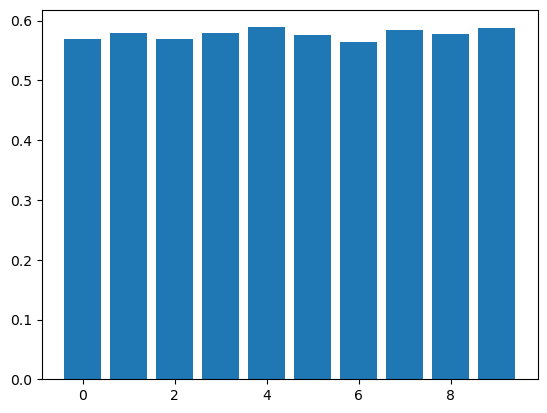

In [6]:
import matplotlib.pyplot as plt

print("Weight norm of each class part of classifier")
print(torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))).cpu().detach().numpy())

plt.show()

#  HeatMap of weight bias

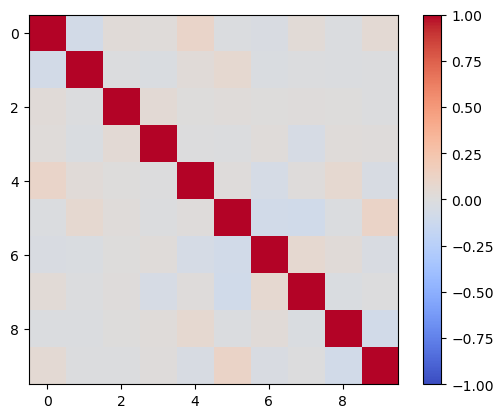

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)).cpu().detach().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

# Get a feature centroid vector and each vector's norm and cosine similarity each other (Test Data) 

In [8]:
                model.eval()
                
                label= [i for i in range(num_classes)]
                
                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = model.extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]


                #Get a inner product of centroids

                cos_sim_hist={}

                with torch.no_grad():
                    inner_product_hist={key: 0 for key in class_mean_dict.keys()}
                    for images, labels in ldr_test:
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = model.extract_features(images)
                        for i in range(len(label)):

                            mean_feature=class_mean_dict[label[i]]

                            normalized_mean_feature=mean_feature/torch.norm(mean_feature)

                            class_mask = labels == label[i]  # "cat" 클래스의 마스크를 생성합니다.

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 평균 벡터를 계산합니다.
                                class_features = features[class_mask]
                                normalized_class_features=nn.functional.normalize(class_features, p=2, dim=1)

                                inner_product=torch.mm(normalized_class_features, normalized_mean_feature.unsqueeze(1))
                                if label[i] not in cos_sim_hist.keys():
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.array([inner_product.squeeze().cpu().numpy()[()]])
                                    else:
                                        cos_sim_hist[label[i]]=inner_product.squeeze().cpu().numpy()
                                else:
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], np.array([inner_product.squeeze().cpu().numpy()[()]])), axis=0)

                                    else:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], inner_product.squeeze().cpu().numpy()), axis=0)

                                        
                cos_sim_mean={}
                cos_sim_var={}

                for key in class_sums.keys():
                    if key in class_counts:
                        cos_sim_mean[key] = cos_sim_hist[key].mean()
                        cos_sim_var[key] = cos_sim_hist[key].var()
                print("-------------------MEAN-------------------")                

                print(cos_sim_mean)
                print("-------------------VAR-------------------")                

                print(cos_sim_var)



-------------------MEAN-------------------
{0: 0.9853856, 1: 0.98083365, 2: 0.97855103, 3: 0.9882902, 4: 0.9908862, 5: 0.989297, 6: 0.9769133, 7: 0.9934702, 8: 0.9855626, 9: 0.97839075}
-------------------VAR-------------------
{0: 0.00025092397, 1: 0.0010181229, 2: 0.00043272699, 3: 0.00018658908, 4: 8.7645e-05, 5: 0.00014476213, 6: 0.00036829204, 7: 6.01762e-05, 8: 0.00020189873, 9: 0.00060504203}


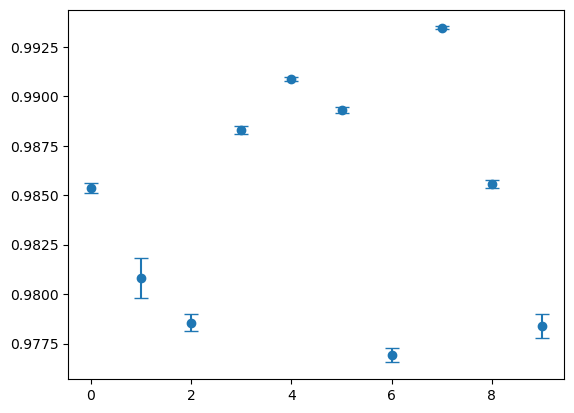

In [9]:
import matplotlib.pyplot as plt


class_index=[i for i in range(num_classes)]

#centroid로부터 cosine similarity 값들의 mean, variance
classwise_mean=list(cos_sim_mean.values())
classwise_var=list(cos_sim_var.values())

plt.errorbar(class_index, classwise_mean, classwise_var, fmt='o', capsize=5)

plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [10]:
model.eval()
label= [i for i in range(num_classes)]                    


ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
class_sums = {i: None for i in label}
class_counts = {i: None for i in label}



with torch.no_grad():
    for idx, (images, labels) in enumerate(ldr_test):
        images, labels = images.to(args.device), labels.to(args.device)
        features = model.extract_features(images)

        for i in range(len(label)):
            class_mask = labels == label[i]  

            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                class_features = features[class_mask]
                class_sum = class_features.sum(dim=0)
                count=class_features.shape[0]

                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                    class_sums[label[i]]=class_sum
                    class_counts[label[i]]=count
                else:
                    class_sums[label[i]]+=class_sum
                    class_counts[label[i]]+=count

#Get the class-wise feature centroid                    
class_mean_dict={}
for key, value in class_sums.items():
    if key in class_counts:
        class_mean_dict[key] = value / class_counts[key]

print(class_mean_dict)
#Get a Inner product of each class's centroid vector

sorted_keys=sorted(class_mean_dict)
print(sorted_keys)

class_mean_lst=[]


for key in sorted_keys:
    class_mean_lst.append(class_mean_dict[key])

class_mean_lst=torch.stack(class_mean_lst)


print(class_mean_lst.shape)
print(class_mean_lst.transpose(0,1).shape)

#Get the each centroid vector's norm
print("-------------Norm of each centroid vectors --------------")
print(torch.diagonal(torch.mm(class_mean_lst, class_mean_lst.transpose(0,1))))


#Get the cosine similarity result between eacn centroid vectors


normalized_class_mean_lst=nn.functional.normalize(class_mean_lst, p=2, dim=1)
print("-------------Cosine similarity of Each Centroid vectors--------------")
print(torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy())

                    
    


{0: tensor([4.9241e+00, 4.2193e+00, 0.0000e+00, 1.8715e-01, 3.0815e+00, 0.0000e+00,
        1.0332e+01, 1.6208e+00, 6.5511e+00, 0.0000e+00, 0.0000e+00, 2.4253e-01,
        1.1334e+01, 1.1664e+01, 0.0000e+00, 0.0000e+00, 6.7932e+00, 2.2444e+00,
        4.7414e+00, 8.9702e+00, 0.0000e+00, 8.7437e+00, 0.0000e+00, 8.4488e-01,
        8.1631e+00, 6.8029e+00, 7.0428e+00, 7.8426e+00, 9.8164e+00, 0.0000e+00,
        5.4523e-01, 0.0000e+00, 1.9696e+01, 3.5060e+00, 3.5911e+00, 1.3227e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1035e+01, 9.1405e+00,
        2.9017e-02, 8.1185e-02, 0.0000e+00, 1.5377e+01, 8.9338e-03, 9.3617e+00,
        1.0852e+01, 1.9317e+00, 3.1155e-01, 2.6964e-01, 0.0000e+00, 6.6781e+00,
        4.8858e+00, 0.0000e+00, 1.1312e+01, 1.2532e+01, 1.0878e+01, 5.9447e+00,
        1.2820e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.5398e+00, 9.9228e+00,
        9.3063e+00, 0.0000e+00, 0.0000e+00, 3.0832e-01, 4.3673e+00, 1.6924e+00,
        0.0000e+00, 8.6446e+00, 1.86

# Cosine Similarity of Centroid Vectors

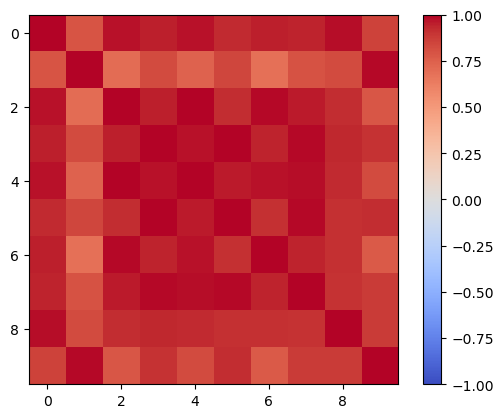

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [12]:
print(type(cos_sim_np))

print(cos_sim_np)

print(cos_sim_np.sum(axis=1))

print(cos_sim_np.sum(axis=0))

<class 'numpy.ndarray'>
[[1.         0.7932645  0.97365975 0.9503534  0.9748532  0.9243898
  0.95125484 0.945141   0.9789354  0.8585105 ]
 [0.7932645  0.99999994 0.70083034 0.823475   0.7384523  0.8408636
  0.6864537  0.8038081  0.82747704 0.9873259 ]
 [0.97365975 0.70083034 1.         0.94567794 0.993245   0.91944873
  0.98662895 0.9566663  0.92031413 0.7851223 ]
 [0.9503534  0.823475   0.94567794 1.         0.9716312  0.99532986
  0.9436169  0.9863387  0.93553644 0.9003163 ]
 [0.9748532  0.7384523  0.993245   0.9716312  1.0000001  0.9539929
  0.9762411  0.98181456 0.9256754  0.8237892 ]
 [0.9243898  0.8408636  0.91944873 0.99532986 0.9539929  1.
  0.913933   0.985703   0.90780383 0.91440386]
 [0.95125484 0.6864537  0.98662895 0.9436169  0.9762411  0.913933
  1.0000001  0.93888754 0.91275287 0.77225333]
 [0.945141   0.8038081  0.9566663  0.9863387  0.98181456 0.985703
  0.93888754 1.0000001  0.89980215 0.88174266]
 [0.9789354  0.82747704 0.92031413 0.93553644 0.9256754  0.90780383
  0

# Centroid-Feature Alignment

In [13]:
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

tensor([0.1109, 0.2124, 0.1070, 0.0749, 0.0870, 0.0957, 0.1559, 0.0955, 0.1556,
        0.1707], device='cuda:6', grad_fn=<DiagonalBackward0>)


Centroid-Feature Alignment of each class
tensor([0.1109, 0.2124, 0.1070, 0.0749, 0.0870, 0.0957, 0.1559, 0.0955, 0.1556,
        0.1707], device='cuda:6', grad_fn=<DiagonalBackward0>)


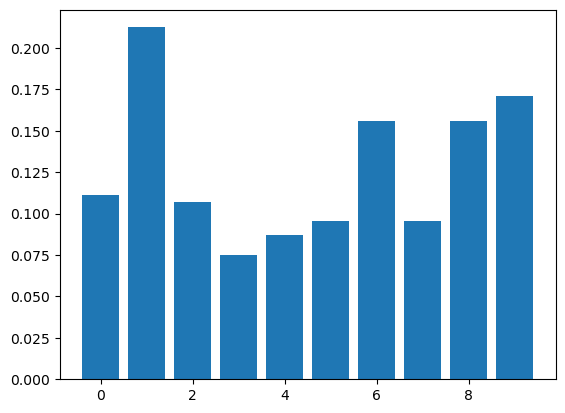

In [14]:
import matplotlib.pyplot as plt

print("Centroid-Feature Alignment of each class")
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))).cpu().detach().numpy())

plt.show()

# Gihun(FedNTD)

In [15]:
    model_key = [name for name, p in model.named_parameters()]
    print(model_key)

['features.0.weight', 'features.0.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.11.weight', 'features.11.bias', 'features.13.weight', 'features.13.bias', 'features.16.weight', 'features.16.bias', 'features.18.weight', 'features.18.bias', 'fc.0.weight', 'fc.0.bias', 'fc.2.weight', 'fc.2.bias', 'classifier.weight', 'classifier.bias']


In [16]:
    info_param = [p for name, p in model.named_parameters() if 'fc.2.weight' in name]

    #Get the innerproduct of the classifier part

    print(info_param[0].shape)
    print(len(info_param))


torch.Size([512, 512])
1


In [17]:
print(class_mean_dict[0].shape)

torch.Size([512])


In [18]:
print(torch.transpose(info_param[0], 0, 1)[0].shape)

torch.Size([512])


In [19]:
print(torch.transpose(info_param[0], 0, 1).shape)

torch.Size([512, 512])


In [20]:
list_storage=[]


print(torch.matmul(torch.transpose(info_param[0], 0, 1), class_mean_dict[0]))
print(torch.matmul(torch.transpose(info_param[0], 0, 1), class_mean_dict[0]).shape)


for index in range(10):

    class_info=torch.matmul(torch.transpose(info_param[0], 0, 1), class_mean_dict[index])

    list_storage.append(class_info)
    
print(len(list_storage))    

print(list_storage[0].size())
final= torch.stack((list_storage[0], list_storage[1], list_storage[2], list_storage[3], list_storage[4], list_storage[5], list_storage[6], list_storage[7], list_storage[8], list_storage[9]), dim=0)    


print(final)

print(final.shape)


# 각 행에서 최댓값을 가진 행의 인덱스 추출
max_indices = torch.argmax(final, dim=0).to('cpu').numpy()

print(max_indices)
print(len(max_indices))

tensor([ 3.3319e-02, -1.2311e+00,  1.3070e+00, -4.4923e+00,  1.0278e+01,
         6.0359e-01,  3.7478e+01, -6.3090e+00,  1.0507e+01, -2.2125e+00,
        -2.5340e+00,  8.3014e+00,  2.5183e+01,  7.8430e+00,  1.3860e+01,
         2.7344e+01,  1.6870e+01, -4.2201e+00, -7.7377e-01,  1.2345e+01,
         2.3953e+01,  1.7878e+01,  4.2023e+00,  3.5935e+00, -2.2235e+00,
         5.0539e+00,  1.7492e+01,  7.1894e+00, -5.3996e+00, -2.9353e+00,
         9.1438e+00,  4.0719e+00,  8.4819e+00,  2.8437e-01,  3.3313e+00,
        -2.8237e+00,  1.4366e+00,  2.6711e+01,  2.5012e+00,  5.7072e+00,
         2.1738e+01,  4.2055e+00,  3.0021e+01,  2.9452e+01,  1.8372e+01,
        -1.1330e+00, -2.2164e+00, -1.5055e+00,  4.4999e+00,  1.3868e+01,
        -3.1034e+00,  3.9061e+00,  3.8544e+00, -2.1086e+00,  2.8530e+00,
        -2.2139e+00,  1.8731e+01,  3.8994e+00,  5.0429e+00,  7.5985e+00,
         6.2246e-01,  6.5424e+01,  4.4654e+00,  1.7935e+00,  7.2983e+00,
         2.5886e+00,  1.2685e+00,  2.2969e+01, -7.0

파이썬의 Matplotlib 라이브러리를 사용하여 10개의 구분 잘되는 색을 추천해 드릴 수 있습니다. 다음은 추천하는 색상 목록입니다:

#1f77b4 (파란색)
#ff7f0e (주황색)
#2ca02c (녹색)
#d62728 (빨간색)
#9467bd (보라색)
#8c564b (갈색)
#e377c2 (분홍색)
#7f7f7f (회색)
#bcbd22 (옐로우)
#17becf (청록색)

In [21]:
color_dict={0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c", 3:"#d62728", 4: "#9467bd", 5: "#8c564b", 6: "#e377c2", 7: "#7f7f7f", 8: "#bcbd22", 9: "#17becf" }

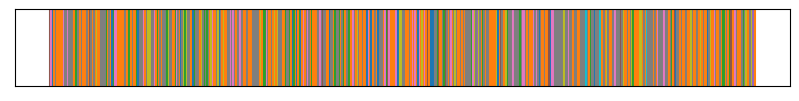

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 1))

for i in range(len(max_indices)):
    plt.plot((i, i), (0, 1), scaley=False, color=color_dict[max_indices[i].item()])

plt.xticks([])  # x축 눈금 숨김
plt.yticks([])  # y축 눈금 숨김

# 그래프를 저장할 디렉토리 경로 설정
save_dir = 'Analysis_figure/ntd/shard2/body/0.001/'

# 그래프 저장
plt.savefig(save_dir + 'DG_default.png')


plt.show()


In [23]:
def find_permutation(lst):
    sorted_indices = sorted(range(len(lst)), key=lambda x: lst[x])
    return sorted_indices

In [24]:
permutation_func = find_permutation(max_indices)
print(permutation_func)

permuted_max_indices= [max_indices[i] for i in permutation_func]

[2, 45, 64, 95, 104, 123, 176, 179, 182, 203, 230, 233, 238, 252, 253, 267, 276, 277, 278, 325, 355, 363, 395, 454, 477, 3, 5, 6, 7, 8, 9, 17, 18, 22, 24, 25, 26, 28, 31, 33, 35, 36, 42, 44, 49, 50, 51, 52, 53, 56, 59, 61, 62, 69, 77, 79, 81, 89, 90, 94, 102, 103, 109, 116, 119, 120, 125, 127, 128, 135, 141, 142, 144, 145, 146, 152, 154, 159, 160, 162, 164, 169, 170, 175, 178, 180, 183, 185, 189, 191, 192, 193, 201, 202, 206, 211, 214, 218, 219, 222, 225, 226, 228, 229, 232, 234, 235, 237, 242, 247, 248, 249, 250, 258, 259, 260, 262, 264, 266, 269, 271, 273, 275, 283, 284, 289, 292, 296, 297, 299, 301, 313, 316, 319, 320, 321, 322, 323, 326, 329, 330, 346, 348, 349, 350, 357, 358, 360, 361, 379, 380, 383, 384, 391, 400, 401, 403, 406, 407, 417, 418, 420, 424, 425, 426, 427, 430, 432, 438, 440, 449, 452, 457, 459, 460, 463, 464, 467, 468, 471, 473, 475, 476, 480, 481, 484, 485, 487, 490, 492, 495, 496, 499, 500, 501, 506, 507, 511, 19, 41, 46, 57, 58, 63, 78, 85, 91, 98, 105, 112, 114, 

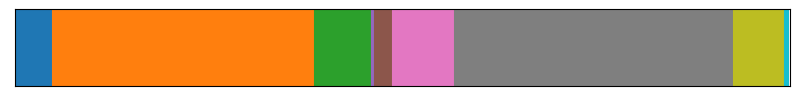

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 1))

for i in range(len(max_indices)):
    plt.plot((i, i), (0, 1), scaley=False, color=color_dict[permuted_max_indices[i].item()])
plt.xlim(0, len(max_indices))
plt.xticks([])  # x축 눈금 숨김
plt.yticks([])  # y축 눈금 숨김

# 그래프를 저장할 디렉토리 경로 설정
save_dir = 'Analysis_figure/ntd/shard2/body/0.001/'

# 그래프 저장
plt.savefig(save_dir + 'DG.png')


plt.show()


# Generate Local Model

In [26]:
def get_class_mean_dict(model, num_classes, dataset_test, args):

    model.eval()
    label= [i for i in range(num_classes)]                    


    ldr_test = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)
    class_sums = {i: None for i in label}
    class_counts = {i: None for i in label}



    with torch.no_grad():
        for idx, (images, labels) in enumerate(ldr_test):
            images, labels = images.to(args.device), labels.to(args.device)
            features = model.extract_features(images)

            for i in range(len(label)):
                class_mask = labels == label[i]  

                if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                    class_features = features[class_mask]
                    class_sum = class_features.sum(dim=0)
                    count=class_features.shape[0]

                    if class_sums[label[i]]== None and class_counts[label[i]] == None:
                        class_sums[label[i]]=class_sum
                        class_counts[label[i]]=count
                    else:
                        class_sums[label[i]]+=class_sum
                        class_counts[label[i]]+=count

    #Get the class-wise feature centroid                    
    class_mean_dict={}
    for key, value in class_sums.items():
        if key in class_counts:
            class_mean_dict[key] = value / class_counts[key]
            
    return class_mean_dict


In [27]:
def get_local_figure(info_param, class_mean_dict, local_index):

    list_storage=[]



    for index in range(10):

        class_info=torch.matmul(torch.transpose(info_param[0], 0, 1), class_mean_dict[index])

        list_storage.append(class_info)


    final= torch.stack((list_storage[0], list_storage[1], list_storage[2], list_storage[3], list_storage[4], list_storage[5], list_storage[6], list_storage[7], list_storage[8], list_storage[9]), dim=0)    

    # 각 행에서 최댓값을 가진 행의 인덱스 추출
    max_indices = torch.argmax(final, dim=0).to('cpu').numpy()

    permuted_max_indices= [max_indices[i] for i in permutation_func]


    if local_index%10==0:
        plt.figure(figsize=(10, 1))

        for i in range(len(max_indices)):
            plt.plot((i, i), (0, 1), scaley=False, color=color_dict[permuted_max_indices[i].item()])
        plt.xlim(0, len(max_indices))
        plt.xticks([])  # x축 눈금 숨김
        plt.yticks([])  # y축 눈금 숨김

        # 그래프를 저장할 디렉토리 경로 설정
        save_dir = 'Analysis_figure/ntd/shard2/body/0.001/'

        # 그래프 저장
        plt.savefig(save_dir + 'Local_{}.png'.format(local_index))


In [28]:
def get_aggregated_figure(info_param, class_mean_dict):

    list_storage=[]



    for index in range(10):

        class_info=torch.matmul(torch.transpose(info_param[0], 0, 1), class_mean_dict[index])

        list_storage.append(class_info)


    final= torch.stack((list_storage[0], list_storage[1], list_storage[2], list_storage[3], list_storage[4], list_storage[5], list_storage[6], list_storage[7], list_storage[8], list_storage[9]), dim=0)    

    # 각 행에서 최댓값을 가진 행의 인덱스 추출
    max_indices = torch.argmax(final, dim=0).to('cpu').numpy()

    permuted_max_indices= [max_indices[i] for i in permutation_func]



    plt.figure(figsize=(10, 1))

    for i in range(len(max_indices)):
        plt.plot((i, i), (0, 1), scaley=False, color=color_dict[permuted_max_indices[i].item()])
    plt.xlim(0, len(max_indices))
    plt.xticks([])  # x축 눈금 숨김
    plt.yticks([])  # y축 눈금 숨김

    # 그래프를 저장할 디렉토리 경로 설정
    save_dir = 'Analysis_figure/ntd/shard2/body/0.001/'

    # 그래프 저장
    plt.savefig(save_dir + 'AG.png')


Files already downloaded and verified
Files already downloaded and verified
-----------------------------------------------------
Client: 0
66.0
After
98.0
-----------------------------------------------------
Client: 1
69.0
After
95.0
-----------------------------------------------------
Client: 2
70.0
After
97.0
-----------------------------------------------------
Client: 3
68.0
After
98.0
-----------------------------------------------------
Client: 4
69.0
After
98.0
-----------------------------------------------------
Client: 5
62.0
After
97.0
-----------------------------------------------------
Client: 6
72.0
After
97.0
-----------------------------------------------------
Client: 7
72.0
After
99.0
-----------------------------------------------------
Client: 8
66.0
After
99.0
-----------------------------------------------------
Client: 9
70.0
After
98.0
-----------------------------------------------------
Client: 10
67.0
After
95.0
-------------------------------------------

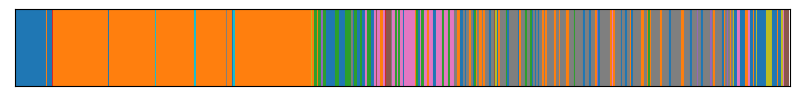

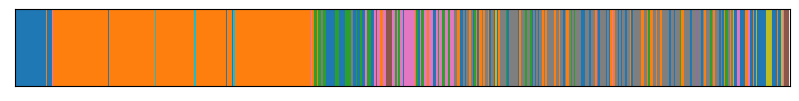

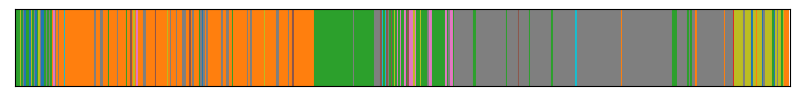

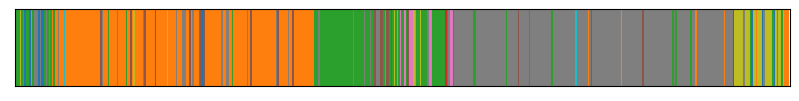

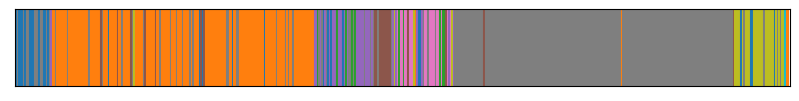

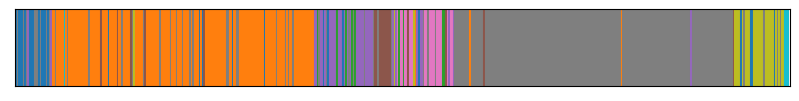

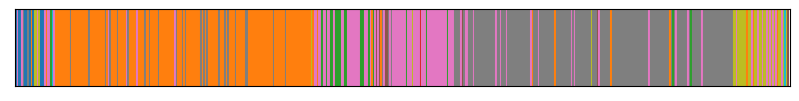

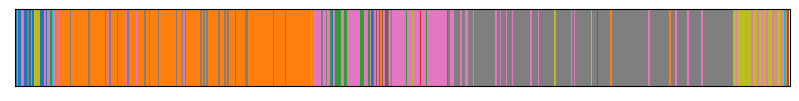

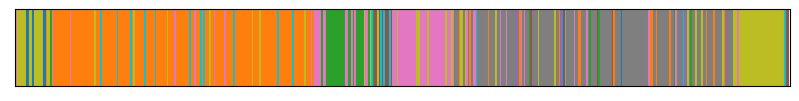

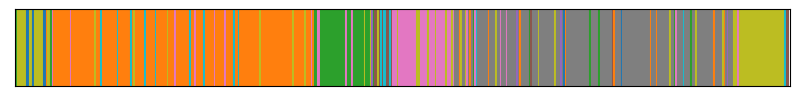

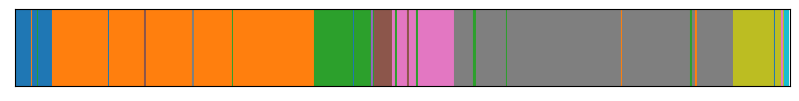

In [29]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [2]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('body', 'body')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 6,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}_new/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)


                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
                dict_save_path = 'setting_3.pkl'
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)

                # build model
                net_glob = get_model(args)
                net_glob.train()

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []

                w_glob = None
                data_size=[]

                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)

                    print ("-----------------------------------------------------")
                    print ("Client: {}".format(user))

                    print(acc_test)

                    net_local.train()
                    ldr_train = DataLoader(DatasetSplit(dataset_train, dict_users_train[user]), batch_size=args.bs, shuffle=True)

                    body_params = [p for name, p in net_local.named_parameters() if 'classifier' not in name]
                    head_params = [p for name, p in net_local.named_parameters() if 'classifier' in name]
                    optimizer = torch.optim.SGD([{'params': body_params, 'lr': 0.001},
                                                 {'params': head_params, 'lr': 0.0}],
                                                momentum=args.momentum, weight_decay=args.wd)#full update!!

                    for iter in range(args.local_ep):
                        for batch_idx, (images, labels) in enumerate(ldr_train):
                            images, labels = images.to(args.device), labels.to(args.device)
                            net_local.zero_grad()
                            logits = net_local(images)

                            loss = criterion(logits, labels)
                            loss.backward()
                            optimizer.step()

                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    after_acc_results.append(acc_test)#pretrain 이후의 personalized accuracy 기재!!
                    print('After')
                    print(acc_test)


                    #Get a Local Model figure

                    class_mean_dict=get_class_mean_dict(net_local, num_classes, dataset_test, args)
                    info_param = [p for name, p in net_local.named_parameters() if 'fc.2.weight' in name]

                    get_local_figure(info_param, class_mean_dict, user)


                    train_size=len(dict_users_train[user])

                    data_size.append(train_size)

                    if w_glob is None:
                        w_glob = copy.deepcopy(net_local.state_dict())
                    else:
                        for k in w_glob.keys():
                            w_glob[k] += net_local.state_dict()[k]

                # Aggregation
                for k in w_glob.keys():
                    w_glob[k] = torch.div(w_glob[k], args.num_users)

                agg_net= get_model(args)   

                agg_net.load_state_dict(w_glob)    
                class_mean_dict=get_class_mean_dict(agg_net, num_classes, dataset_test, args)
                info_param = [p for name, p in agg_net.named_parameters() if 'fc.2.weight' in name]



                get_aggregated_figure(info_param, class_mean_dict)                
                agg_accuracy, agg_test_loss =test_img_global(agg_net, dataset_test, args)
                print ("-----------------------------------------------------")
                print ("local update part: {}, aggregation part: {}".format(local_upt_part, aggr_part))
                print ("iid, frac: {}, local_ep: {}".format(frac, local_ep))
                print ("Before min/max/mean/std of accuracy")
                print (np.min(before_acc_results), np.max(before_acc_results), np.mean(before_acc_results), round(np.std(before_acc_results), 2))
                print ("After min/max/mean/std of accuracy")
                print (np.min(after_acc_results), np.max(after_acc_results), np.mean(after_acc_results), round(np.std(after_acc_results), 2))
                print ("-----------------------------------------------------")

                print ("Accuracy of Aggregated Model")
                print (agg_accuracy)
                print ("-----------------------------------------------------")            